**Objective**: Build an CNN based image classifier (at least 3 - 5 categories) from a custom data set you acquire (either from images.google.com or other place)

**Reference**: 
* https://keras.io/examples/vision/image_classification_from_scratch/
* For google image - https://colab.research.google.com/github/fastai/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb#scrollTo=UxMJK_UJbIAO 
* For model enhancement - https://developers.google.com/codelabs/tensorflow-4-cnns?hl=en&continue=https%3A%2F%2Fcodelabs.developers.google.com%2F#0

Extra points : If you create your own pooling layer- https://www.tensorflow.org/tutorials/customization/custom_layers 



In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from fastai.vision import *

# Google Image Custom Dataset 
* Search for 4 types of goldfish (Regular, Panda Telescope, Calico, Jikin) images on Google and download urls
* Use fastai.vision to download image using urls
* Dataset shape: 520


In [2]:
classes = ['goldfish','panda_goldfish','calico_goldfish','jikin_goldfish']
path = Path('images/')

In [3]:
def download_image(subject, path):
  folder = subject
  file = subject + '.csv'
  dest = path/folder
  dest.mkdir(parents=True, exist_ok=True)
  download_images(path/file, dest, max_pics=200)

for i in classes:
  download_image(i,path)

In [4]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

goldfish


panda_goldfish


calico_goldfish


jikin_goldfish


In [5]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
data.classes

['calico_goldfish', 'goldfish', 'jikin_goldfish', 'panda_goldfish']

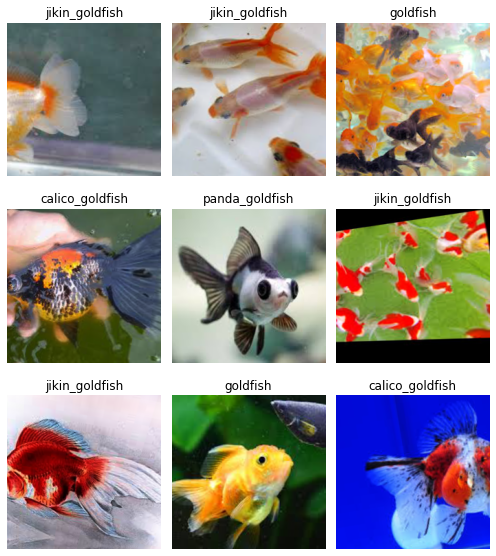

In [67]:
data.show_batch(rows=3, figsize=(7,8))

# Data Preprocessing

In [7]:
import os

num_skipped = 0
for folder_name in classes:
    folder_path = os.path.join("images", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [8]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "images",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "images",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 720 files belonging to 4 classes.
Using 576 files for training.
Found 720 files belonging to 4 classes.
Using 144 files for validation.


## Image Augmentation
* Add layer in make model function

In [9]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)
plt.figure(figsize=(10, 10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

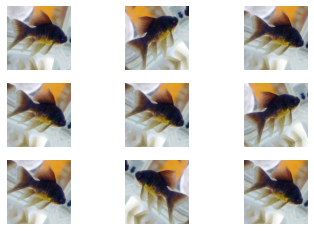

In [10]:
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Configure dataset for performance

In [11]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

# Build CNN Model

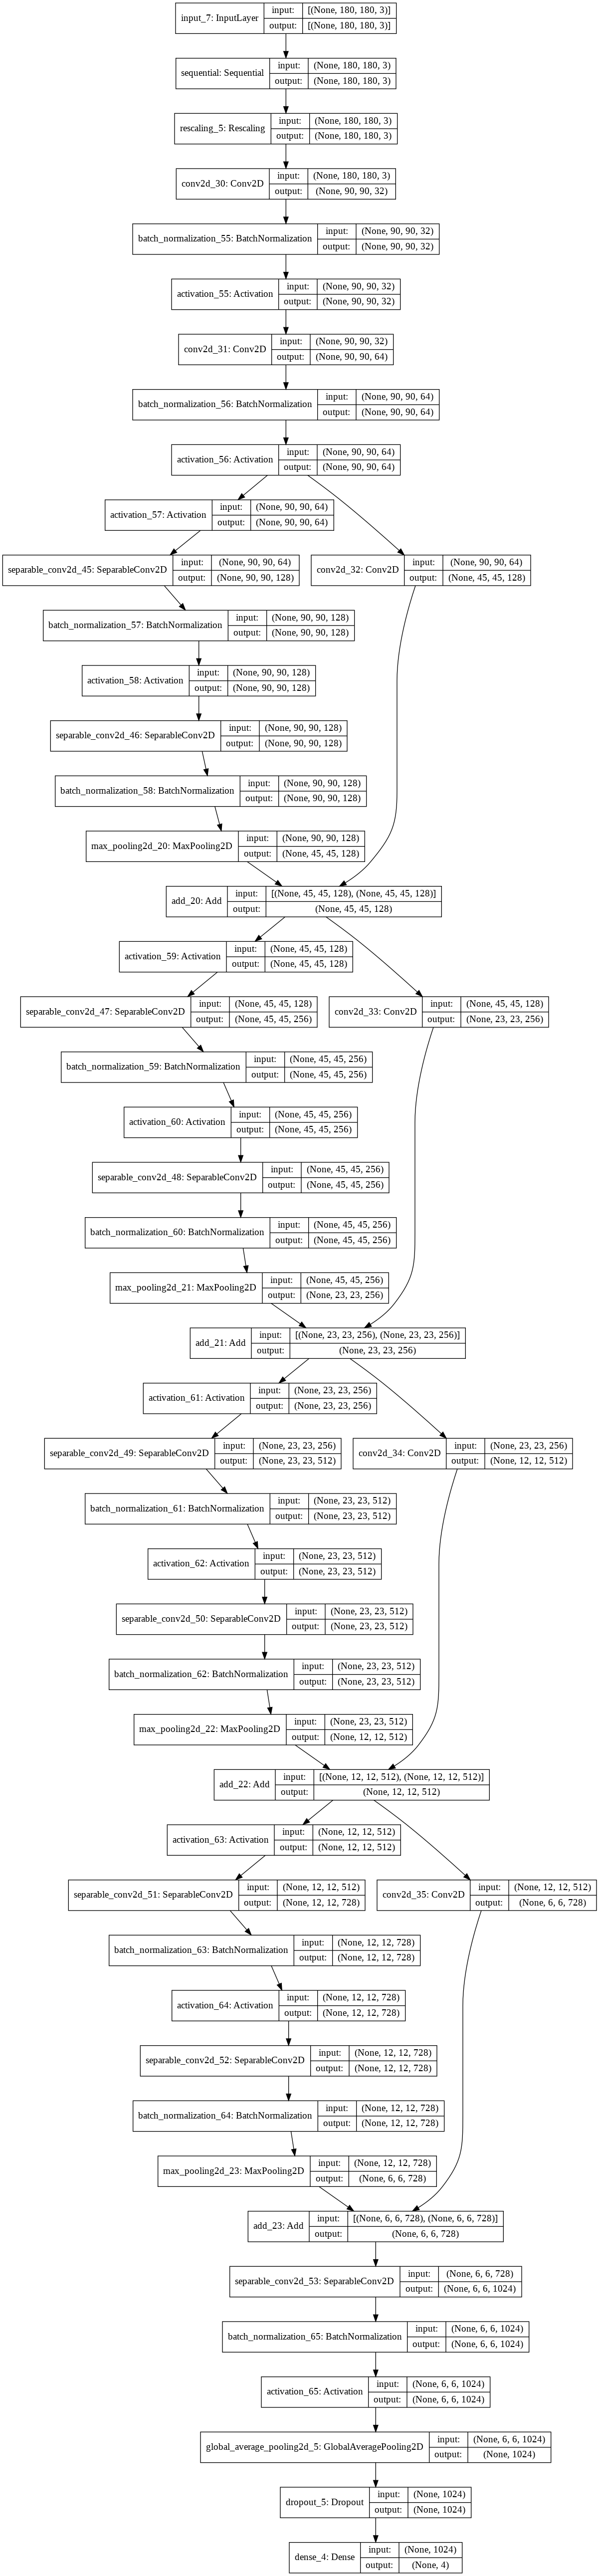

In [30]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x) # Standardized
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=4)
keras.utils.plot_model(model, show_shapes=True)

# Training

In [31]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 180, 180, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
rescaling_5 (Rescaling)         (None, 180, 180, 3)  0           sequential[5][0]                 
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 90, 90, 32)   896         rescaling_5[0][0]                
____________________________________________________________________________________________

In [32]:
model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)

Epoch 1/10
18/18 [==============================] - 149s 8s/step - loss: 1.7189 - accuracy: 0.3400 - val_loss: 1.3861 - val_accuracy: 0.2500
Epoch 2/10
18/18 [==============================] - 142s 8s/step - loss: 1.3211 - accuracy: 0.4279 - val_loss: 1.3834 - val_accuracy: 0.3056
Epoch 3/10
18/18 [==============================] - 142s 8s/step - loss: 1.3011 - accuracy: 0.4163 - val_loss: 1.3831 - val_accuracy: 0.3056
Epoch 4/10
18/18 [==============================] - 142s 8s/step - loss: 1.3287 - accuracy: 0.4285 - val_loss: 1.3872 - val_accuracy: 0.3056
Epoch 5/10
18/18 [==============================] - 151s 8s/step - loss: 1.2047 - accuracy: 0.4829 - val_loss: 1.3864 - val_accuracy: 0.3056
Epoch 6/10
18/18 [==============================] - 146s 8s/step - loss: 1.1823 - accuracy: 0.4512 - val_loss: 1.3996 - val_accuracy: 0.3056
Epoch 7/10
18/18 [==============================] - 144s 8s/step - loss: 1.1327 - accuracy: 0.5070 - val_loss: 1.4018 - val_accuracy: 0.3056
Epoch 8/10
18